In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [ ]:
import pathlib
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.functional import interpolate
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, Discriminator

In [ ]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

## Prepare Data

In [ ]:
sites = {
    "SO2",
    # "FR-BIL",
    # "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(f"Num train {len(train_patches)}\n" f"Num test {len(test_patches)}")

In [ ]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [ ]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [ ]:
train_loader = DataLoader(train_patches, batch_size=100)

In [ ]:
(low_res, high_res) = next(train_loader.__iter__())

In [ ]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

## Training

In [ ]:
# For clearing GPU memory
# 1 / 0

In [ ]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [286]:
BATCH_SIZE = 16
GEN_LEARNING_RATE = 1e-5
DISCRIM_LEARNING_RATE = 1e-5
GEN_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT = 1e-4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    pin_memory=should_pin_memory[device.type],
    num_workers=0,
)

In [ ]:
device

In [ ]:
generator = SRResNet(scaling_factor=2, n_blocks=8)

In [ ]:
discriminator = Discriminator(n_blocks=8, fc_size=512)

In [483]:
generator = generator.to(device)
generator = generator.train()

In [ ]:
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [ ]:
gen_optimizer = optim.Adam(
    generator.parameters(), lr=GEN_LEARNING_RATE, weight_decay=GEN_WEIGHT_DECAY
)

discrim_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=DISCRIM_LEARNING_RATE,
    weight_decay=DISCRIM_WEIGHT_DECAY,
)

In [ ]:
# save_file = RESULTS_DIR / "srganreal_gen_only.pkl"
# loaded_experiment = torch.load(save_file, map_location=device)
# # generator = SRResNet(scaling_factor=2, n_blocks=16).to(device)
# # discriminator = Discriminator(n_blocks=3, fc_size=128)
# generator.load_state_dict(loaded_experiment["gen_state"])
# discriminator.load_state_dict(loaded_experiment["discrim_state"])
# gen_optimizer.load_state_dict(loaded_experiment["gen_optimizer_state"])
# discrim_optimizer.load_state_dict(loaded_experiment["discrim_optimizer_state"])
# gen_losses = loaded_experiment["gen_losses"]
# discrim_losses = loaded_experiment["discrim_losses"]

In [ ]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [ ]:
NUM_EPOCHS = 2000

In [ ]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [484]:
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    num_batches = 0
    for i, (low_res_batch, high_res_batch) in enumerate(progress_bar):
        num_batches += 1
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch)  # .clamp(0, 1)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        adversarial_loss = discrim_criterion(
            natural_probs, torch.ones_like(natural_probs)
        )
        gen_loss = pixel_loss

        gen_loss += DISCRIM_WEIGHT * adversarial_loss

        if i % 5 == 0:
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.zeros_like(fake_natural_probs)
        )
        discrim_loss = true_natural_loss + fake_natural_loss

        # if gen_loss.item() < 0.0005:
        discrim_optimizer.zero_grad()
        discrim_loss.backward()
        discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(
            epoch=epoch,
            gen_loss=f"{gen_epoch_loss/num_batches:.8f}",
            discrim_loss=f"{discrim_epoch_loss/num_batches:.8f}",
        )

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.8f}"
    )

100%|████████| 32/32 [00:15<00:00,  2.09it/s, discrim_loss=0.00030351, epoch=0, gen_loss=0.00256659]


Epoch: 0 / gen_loss: 0.00256659 / discrim_loss: 0.00030351


100%|████████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00060091, epoch=1, gen_loss=0.00212136]


Epoch: 1 / gen_loss: 0.00212136 / discrim_loss: 0.00060091


100%|████████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00531313, epoch=2, gen_loss=0.00196725]


Epoch: 2 / gen_loss: 0.00196725 / discrim_loss: 0.00531313


100%|████████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00204446, epoch=3, gen_loss=0.00197835]


Epoch: 3 / gen_loss: 0.00197835 / discrim_loss: 0.00204446


100%|████████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00094596, epoch=4, gen_loss=0.00204770]


Epoch: 4 / gen_loss: 0.00204770 / discrim_loss: 0.00094596


100%|████████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00294039, epoch=5, gen_loss=0.00196145]


Epoch: 5 / gen_loss: 0.00196145 / discrim_loss: 0.00294039


100%|████████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00121352, epoch=6, gen_loss=0.00206725]


Epoch: 6 / gen_loss: 0.00206725 / discrim_loss: 0.00121352


100%|████████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00216893, epoch=7, gen_loss=0.00188057]


Epoch: 7 / gen_loss: 0.00188057 / discrim_loss: 0.00216893


100%|████████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00155560, epoch=8, gen_loss=0.00215002]


Epoch: 8 / gen_loss: 0.00215002 / discrim_loss: 0.00155560


100%|████████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00008678, epoch=9, gen_loss=0.00196020]


Epoch: 9 / gen_loss: 0.00196020 / discrim_loss: 0.00008678


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00057511, epoch=10, gen_loss=0.00186105]


Epoch: 10 / gen_loss: 0.00186105 / discrim_loss: 0.00057511


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00103157, epoch=11, gen_loss=0.00180758]


Epoch: 11 / gen_loss: 0.00180758 / discrim_loss: 0.00103157


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00079194, epoch=12, gen_loss=0.00187716]


Epoch: 12 / gen_loss: 0.00187716 / discrim_loss: 0.00079194


100%|███████| 32/32 [00:15<00:00,  2.08it/s, discrim_loss=0.00346040, epoch=13, gen_loss=0.00185636]


Epoch: 13 / gen_loss: 0.00185636 / discrim_loss: 0.00346040


100%|███████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00152724, epoch=14, gen_loss=0.00174288]


Epoch: 14 / gen_loss: 0.00174288 / discrim_loss: 0.00152724


100%|███████| 32/32 [00:15<00:00,  2.09it/s, discrim_loss=0.00051097, epoch=15, gen_loss=0.00193457]


Epoch: 15 / gen_loss: 0.00193457 / discrim_loss: 0.00051097


100%|███████| 32/32 [00:15<00:00,  2.08it/s, discrim_loss=0.00200778, epoch=16, gen_loss=0.00175125]


Epoch: 16 / gen_loss: 0.00175125 / discrim_loss: 0.00200778


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00100386, epoch=17, gen_loss=0.00197911]


Epoch: 17 / gen_loss: 0.00197911 / discrim_loss: 0.00100386


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00071961, epoch=18, gen_loss=0.00183941]


Epoch: 18 / gen_loss: 0.00183941 / discrim_loss: 0.00071961


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00031639, epoch=19, gen_loss=0.00199197]


Epoch: 19 / gen_loss: 0.00199197 / discrim_loss: 0.00031639


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00062411, epoch=20, gen_loss=0.00199210]


Epoch: 20 / gen_loss: 0.00199210 / discrim_loss: 0.00062411


100%|███████| 32/32 [00:15<00:00,  2.09it/s, discrim_loss=0.00039372, epoch=21, gen_loss=0.00209622]


Epoch: 21 / gen_loss: 0.00209622 / discrim_loss: 0.00039372


100%|███████| 32/32 [00:15<00:00,  2.08it/s, discrim_loss=0.00039311, epoch=22, gen_loss=0.00213006]


Epoch: 22 / gen_loss: 0.00213006 / discrim_loss: 0.00039311


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00069619, epoch=23, gen_loss=0.00229070]


Epoch: 23 / gen_loss: 0.00229070 / discrim_loss: 0.00069619


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00030762, epoch=24, gen_loss=0.00258093]


Epoch: 24 / gen_loss: 0.00258093 / discrim_loss: 0.00030762


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00044598, epoch=25, gen_loss=0.00253461]


Epoch: 25 / gen_loss: 0.00253461 / discrim_loss: 0.00044598


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00126556, epoch=26, gen_loss=0.00249718]


Epoch: 26 / gen_loss: 0.00249718 / discrim_loss: 0.00126556


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00062624, epoch=27, gen_loss=0.00409571]


Epoch: 27 / gen_loss: 0.00409571 / discrim_loss: 0.00062624


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00007747, epoch=28, gen_loss=0.00378769]


Epoch: 28 / gen_loss: 0.00378769 / discrim_loss: 0.00007747


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00009259, epoch=29, gen_loss=0.00346655]


Epoch: 29 / gen_loss: 0.00346655 / discrim_loss: 0.00009259


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00004627, epoch=30, gen_loss=0.00317197]


Epoch: 30 / gen_loss: 0.00317197 / discrim_loss: 0.00004627


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00003804, epoch=31, gen_loss=0.00284803]


Epoch: 31 / gen_loss: 0.00284803 / discrim_loss: 0.00003804


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00003962, epoch=32, gen_loss=0.00243213]


Epoch: 32 / gen_loss: 0.00243213 / discrim_loss: 0.00003962


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00020091, epoch=33, gen_loss=0.00207789]


Epoch: 33 / gen_loss: 0.00207789 / discrim_loss: 0.00020091


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00012719, epoch=34, gen_loss=0.00217320]


Epoch: 34 / gen_loss: 0.00217320 / discrim_loss: 0.00012719


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00020306, epoch=35, gen_loss=0.00199285]


Epoch: 35 / gen_loss: 0.00199285 / discrim_loss: 0.00020306


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00042609, epoch=36, gen_loss=0.00252523]


Epoch: 36 / gen_loss: 0.00252523 / discrim_loss: 0.00042609


100%|███████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00008345, epoch=37, gen_loss=0.00283083]


Epoch: 37 / gen_loss: 0.00283083 / discrim_loss: 0.00008345


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00008645, epoch=38, gen_loss=0.00256193]


Epoch: 38 / gen_loss: 0.00256193 / discrim_loss: 0.00008645


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00006466, epoch=39, gen_loss=0.00221615]


Epoch: 39 / gen_loss: 0.00221615 / discrim_loss: 0.00006466


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00013084, epoch=40, gen_loss=0.00203014]


Epoch: 40 / gen_loss: 0.00203014 / discrim_loss: 0.00013084


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00013479, epoch=41, gen_loss=0.00208624]


Epoch: 41 / gen_loss: 0.00208624 / discrim_loss: 0.00013479


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00009784, epoch=42, gen_loss=0.00207797]


Epoch: 42 / gen_loss: 0.00207797 / discrim_loss: 0.00009784


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00011411, epoch=43, gen_loss=0.00216155]


Epoch: 43 / gen_loss: 0.00216155 / discrim_loss: 0.00011411


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00006295, epoch=44, gen_loss=0.00210681]


Epoch: 44 / gen_loss: 0.00210681 / discrim_loss: 0.00006295


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00010297, epoch=45, gen_loss=0.00203737]


Epoch: 45 / gen_loss: 0.00203737 / discrim_loss: 0.00010297


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00010379, epoch=46, gen_loss=0.00201903]


Epoch: 46 / gen_loss: 0.00201903 / discrim_loss: 0.00010379


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00014484, epoch=47, gen_loss=0.00204105]


Epoch: 47 / gen_loss: 0.00204105 / discrim_loss: 0.00014484


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00009180, epoch=48, gen_loss=0.00204315]


Epoch: 48 / gen_loss: 0.00204315 / discrim_loss: 0.00009180


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00005555, epoch=49, gen_loss=0.00210552]


Epoch: 49 / gen_loss: 0.00210552 / discrim_loss: 0.00005555


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00008376, epoch=50, gen_loss=0.00204094]


Epoch: 50 / gen_loss: 0.00204094 / discrim_loss: 0.00008376


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00007664, epoch=51, gen_loss=0.00213736]


Epoch: 51 / gen_loss: 0.00213736 / discrim_loss: 0.00007664


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00006878, epoch=52, gen_loss=0.00216221]


Epoch: 52 / gen_loss: 0.00216221 / discrim_loss: 0.00006878


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00006196, epoch=53, gen_loss=0.00215050]


Epoch: 53 / gen_loss: 0.00215050 / discrim_loss: 0.00006196


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00006110, epoch=54, gen_loss=0.00212297]


Epoch: 54 / gen_loss: 0.00212297 / discrim_loss: 0.00006110


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00006970, epoch=55, gen_loss=0.00208394]


Epoch: 55 / gen_loss: 0.00208394 / discrim_loss: 0.00006970


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00006390, epoch=56, gen_loss=0.00211398]


Epoch: 56 / gen_loss: 0.00211398 / discrim_loss: 0.00006390


100%|███████| 32/32 [00:15<00:00,  2.11it/s, discrim_loss=0.00007367, epoch=57, gen_loss=0.00212775]


Epoch: 57 / gen_loss: 0.00212775 / discrim_loss: 0.00007367


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00005582, epoch=58, gen_loss=0.00220631]


Epoch: 58 / gen_loss: 0.00220631 / discrim_loss: 0.00005582


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00006909, epoch=59, gen_loss=0.00211556]


Epoch: 59 / gen_loss: 0.00211556 / discrim_loss: 0.00006909


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00008602, epoch=60, gen_loss=0.00207439]


Epoch: 60 / gen_loss: 0.00207439 / discrim_loss: 0.00008602


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00009678, epoch=61, gen_loss=0.00210489]


Epoch: 61 / gen_loss: 0.00210489 / discrim_loss: 0.00009678


100%|███████| 32/32 [00:15<00:00,  2.12it/s, discrim_loss=0.00013639, epoch=62, gen_loss=0.00204098]


Epoch: 62 / gen_loss: 0.00204098 / discrim_loss: 0.00013639


100%|███████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00018038, epoch=63, gen_loss=0.00207475]


Epoch: 63 / gen_loss: 0.00207475 / discrim_loss: 0.00018038


100%|███████| 32/32 [00:15<00:00,  2.10it/s, discrim_loss=0.00005875, epoch=64, gen_loss=0.00214182]


Epoch: 64 / gen_loss: 0.00214182 / discrim_loss: 0.00005875


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00009085, epoch=65, gen_loss=0.00207677]


Epoch: 65 / gen_loss: 0.00207677 / discrim_loss: 0.00009085


100%|███████| 32/32 [00:15<00:00,  2.06it/s, discrim_loss=0.00007683, epoch=66, gen_loss=0.00201381]


Epoch: 66 / gen_loss: 0.00201381 / discrim_loss: 0.00007683


100%|███████| 32/32 [00:15<00:00,  2.05it/s, discrim_loss=0.00009446, epoch=67, gen_loss=0.00206652]


Epoch: 67 / gen_loss: 0.00206652 / discrim_loss: 0.00009446


100%|███████| 32/32 [00:15<00:00,  2.06it/s, discrim_loss=0.00009746, epoch=68, gen_loss=0.00203683]


Epoch: 68 / gen_loss: 0.00203683 / discrim_loss: 0.00009746


100%|███████| 32/32 [00:15<00:00,  2.06it/s, discrim_loss=0.00012423, epoch=69, gen_loss=0.00215634]


Epoch: 69 / gen_loss: 0.00215634 / discrim_loss: 0.00012423


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00007595, epoch=70, gen_loss=0.00221765]


Epoch: 70 / gen_loss: 0.00221765 / discrim_loss: 0.00007595


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00006162, epoch=71, gen_loss=0.00213377]


Epoch: 71 / gen_loss: 0.00213377 / discrim_loss: 0.00006162


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00009238, epoch=72, gen_loss=0.00215567]


Epoch: 72 / gen_loss: 0.00215567 / discrim_loss: 0.00009238


100%|███████| 32/32 [00:15<00:00,  2.06it/s, discrim_loss=0.00007421, epoch=73, gen_loss=0.00221454]


Epoch: 73 / gen_loss: 0.00221454 / discrim_loss: 0.00007421


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00006715, epoch=74, gen_loss=0.00212769]


Epoch: 74 / gen_loss: 0.00212769 / discrim_loss: 0.00006715


100%|███████| 32/32 [00:15<00:00,  2.06it/s, discrim_loss=0.00007365, epoch=75, gen_loss=0.00216925]


Epoch: 75 / gen_loss: 0.00216925 / discrim_loss: 0.00007365


100%|███████| 32/32 [00:15<00:00,  2.08it/s, discrim_loss=0.00005684, epoch=76, gen_loss=0.00222086]


Epoch: 76 / gen_loss: 0.00222086 / discrim_loss: 0.00005684


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00008584, epoch=77, gen_loss=0.00219899]


Epoch: 77 / gen_loss: 0.00219899 / discrim_loss: 0.00008584


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00006377, epoch=78, gen_loss=0.00220231]


Epoch: 78 / gen_loss: 0.00220231 / discrim_loss: 0.00006377


100%|███████| 32/32 [00:15<00:00,  2.08it/s, discrim_loss=0.00006885, epoch=79, gen_loss=0.00226648]


Epoch: 79 / gen_loss: 0.00226648 / discrim_loss: 0.00006885


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00005892, epoch=80, gen_loss=0.00233671]


Epoch: 80 / gen_loss: 0.00233671 / discrim_loss: 0.00005892


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00004455, epoch=81, gen_loss=0.00229908]


Epoch: 81 / gen_loss: 0.00229908 / discrim_loss: 0.00004455


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00007105, epoch=82, gen_loss=0.00230756]


Epoch: 82 / gen_loss: 0.00230756 / discrim_loss: 0.00007105


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00003443, epoch=83, gen_loss=0.00230330]


Epoch: 83 / gen_loss: 0.00230330 / discrim_loss: 0.00003443


100%|███████| 32/32 [00:15<00:00,  2.08it/s, discrim_loss=0.00004878, epoch=84, gen_loss=0.00231366]


Epoch: 84 / gen_loss: 0.00231366 / discrim_loss: 0.00004878


100%|███████| 32/32 [00:15<00:00,  2.07it/s, discrim_loss=0.00006224, epoch=85, gen_loss=0.00227738]


Epoch: 85 / gen_loss: 0.00227738 / discrim_loss: 0.00006224


 50%|███▌   | 16/32 [00:08<00:08,  1.91it/s, discrim_loss=0.00003989, epoch=86, gen_loss=0.00224920]


KeyboardInterrupt: 

In [493]:
train_time / 60

603.3846374273301

In [494]:
len(gen_losses)

2637

In [495]:
gen_losses[-5:]

[0.002299081716046203,
 0.002307563703652704,
 0.0023033043180475943,
 0.0023136556992540136,
 0.00227738224202767]

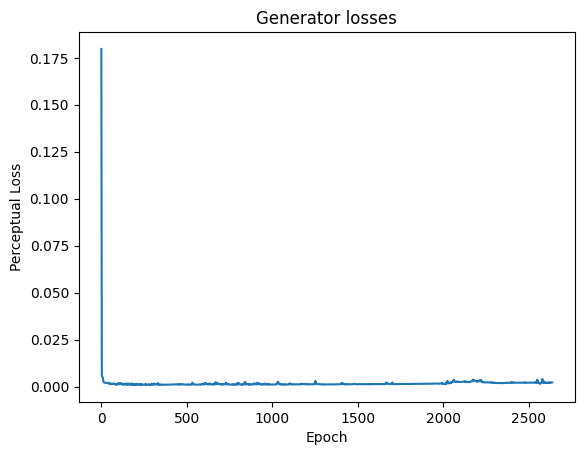

In [496]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

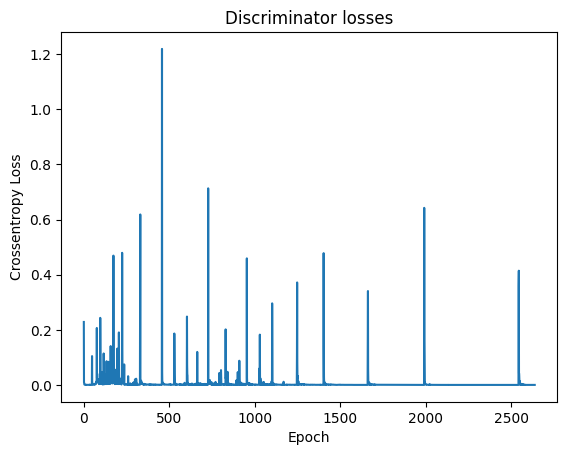

In [497]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

## Saving

In [443]:
experiment = {
    "gen_losses": gen_losses,
    "discrim_losses": discrim_losses,
    "gen_state": generator.state_dict(),
    "discrim_state": discriminator.state_dict(),
    "gen_optimizer_state": gen_optimizer.state_dict(),
    "discrim_optimizer_state": discrim_optimizer.state_dict(),
    "gen_learning_rate": GEN_LEARNING_RATE,
    "discrim_learning_rate": DISCRIM_LEARNING_RATE,
    "gen_weight_decay": GEN_WEIGHT_DECAY,
    "discrim_weight_decay": DISCRIM_WEIGHT_DECAY,
    "discrim_weight": DISCRIM_WEIGHT,
    "train_time": train_time,
}

In [444]:
save_file = RESULTS_DIR / "srganreal_5iterdiscrim2.pkl"

In [445]:
if not save_file.exists():
    torch.save(experiment, save_file)
    print(f"Saved to {save_file}")

Saved to C:\Users\Mitch\stat3007_data\results\srganreal_5iterdiscrim2.pkl


## Generated Examples

In [485]:
generator = generator.to("cpu")

In [325]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

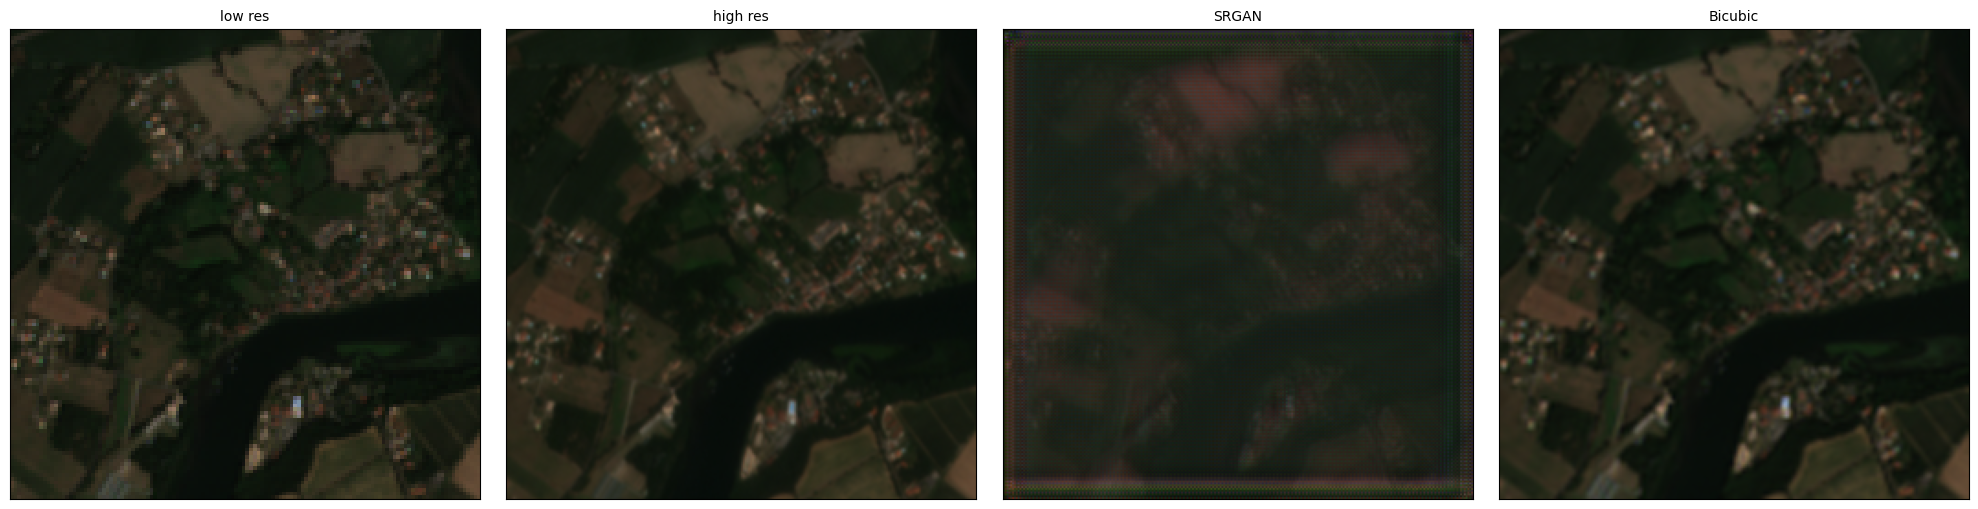

In [492]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [438]:
loader = DataLoader(test_patches, batch_size=300)
(low_res, high_res) = next(loader.__iter__())

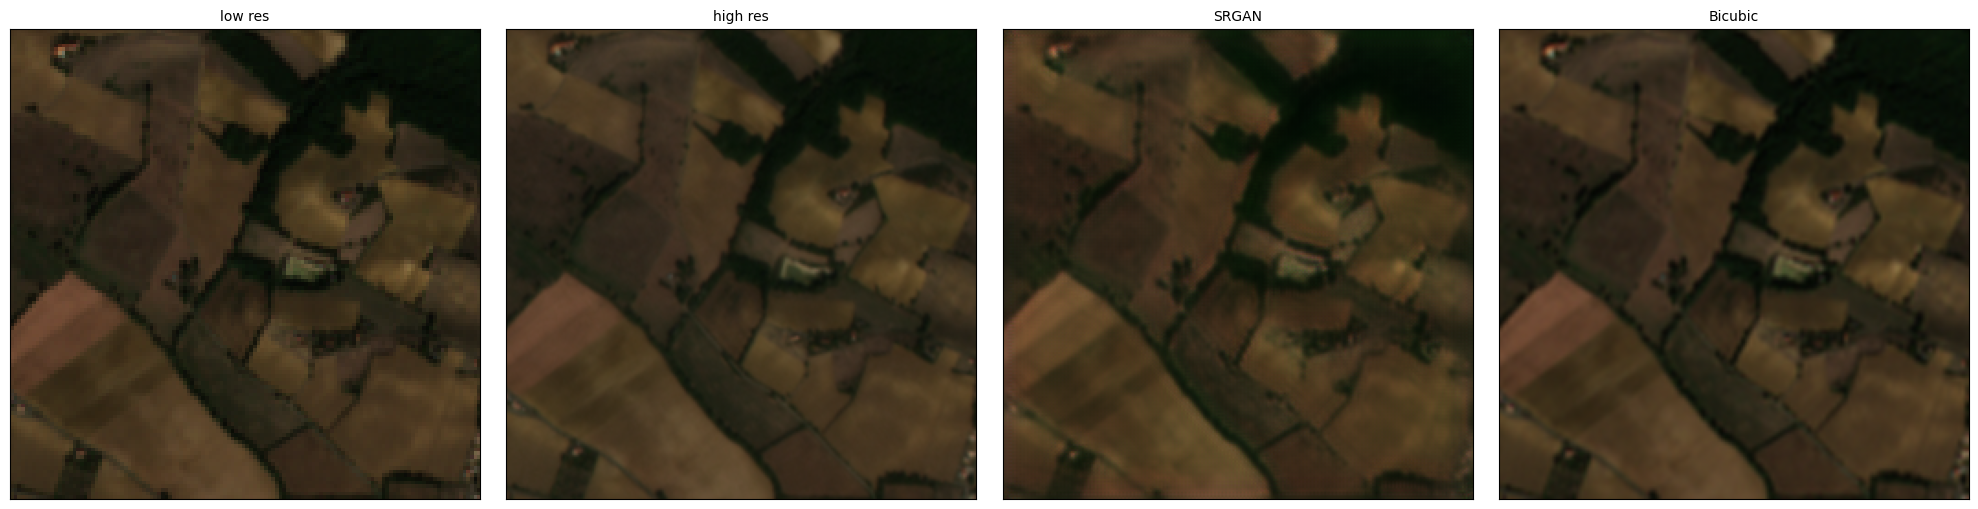

In [447]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]

out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)[0]
out = adjust_brightness(out, 2)

bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)[0]
bicubic_out = adjust_brightness(bicubic_out, 2)

low_res_example = adjust_brightness(low_res_example, 2)
high_res_example = adjust_brightness(high_res_example, 2)

plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out.permute(1, 2, 0),
        bicubic_out.permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

## Save images

In [ ]:
IMAGE_DIR = RESULTS_DIR / "images"

In [ ]:
index

In [ ]:
srgan_file = IMAGE_DIR / f"{index}srgan.png"
bicubic_file = IMAGE_DIR / f"{index}bicubic.png"
low_res_file = IMAGE_DIR / f"{index}lowres.png"
high_res_file = IMAGE_DIR / f"{index}highres.png"

In [ ]:
save_image(low_res_example, low_res_file)
save_image(high_res_example, high_res_file)
save_image(out, srgan_file)
save_image(bicubic_out, bicubic_file)

## Metrics

In [ ]:
del loader

In [448]:
from super_resolution.src.testing import compute_metrics

In [449]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [450]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:54<00:00, 54.18s/it]


In [452]:
metrics

Metrics(mse=0.00010083319648401812, psnr=39.963966369628906, ssim=0.9687812924385071, fid=4.952980041503906)

In [ ]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

In [ ]:
bicubic_metrics